# Set up

In [1]:
import glob # for system ls
# from natsort import natsorted # for alphabetical sorting

import xarray as xr # for reading netcdf
# import numpy as np
import dask.array as da
import dask
import rioxarray as rio # for writing tif
import numpy as np
import os

In [2]:
experiment='Hist'
year='0120'

# input data directories are the same for everyone on HPC Orion
# data_nc = '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/'
# data_static = '/work/hpc/datasets/un_fao/pyaez/static/netcdf/'
data_nc = '/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/'
data_static = '/work/hpc/datasets/un_fao/gaez_v5_intermediate/static/'


# these are output directories, change per user or overwrite files at these locations
# if you change these, make sure the directories exist (mkdir) before running the script
# data_npy = '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/npy/'
# data_tif = '/work/hpc/datasets/un_fao/pyaez/static/tif/'
data_npy = '/work/hpc/datasets/un_fao/pyaez/global_daily/'
data_tif = '/work/hpc/datasets/un_fao/pyaez/global_static/'


varnames = ['Precip','Rhum','Srad','Tmax-2m','Tmin-2m','Wind-2m']
varnames365 = ['Precip365','Rhum365','Srad365','Tmax-2m365','Tmin-2m365','Wind-2m365']

# varnames = ['Rhum']
# varnames365 = ['Rhum365']

# Main Code

# netcdf to npy

In [3]:
# each 3D array has total size ~12.7GB
# we need to chunk these arrays so that a chunk fits into memory (~9GB per single core)
# any chunk size less than ~9GB should work, we'll use 8 chunks --> ~1.5GB per chunk

chunks={'time':-1,'lat':450,'lon':2160} # 8 chunks
# chunks={'time':-1,'lat':200,'lon':-1}

# look at size of the chunks
test=xr.open_dataset(data_nc+'Tmin-2m_'+experiment+'_daily_'+year+'_5m.nc',chunks=chunks)['Tmin-2m'].sel(lat=slice(90,-60.)).transpose('lat','lon','time').data
test

dask.array<transpose, shape=(1800, 4320, 365), dtype=float32, chunksize=(450, 2160, 365), chunktype=numpy.ndarray>

In [10]:
# # this cell outputs all 366 days of data, skip for now

# del test

# # do the nc to npy conversion for each variable
# # we are also subsetting the global array (to eliminate artarctica where all grids are nan)
# # expect about 1 min run time per variable

# for var in varnames:
#     # get nc file name
#     f = natsorted(glob.glob(data_nc+var+'*_5m.nc'))[0]
        
#     if f:
#         # read netcdf data into a dask array of numpy array chunks
#         print('reading',f)
#         data = xr.open_dataset(f,chunks=chunks)[var].sel(lat=slice(90,-60.)).transpose('lat','lon','time').data        

#         # set up dir for writing npy
#         out_dir=data_npy+var+'/'
#         isExist = os.path.exists(out_dir)
#         if not isExist:
#             os.makedirs(out_dir)
#         # write npy data
#         print('writing to',out_dir+'0.npy')     
#         da.to_npy_stack(out_dir,data,axis=2)          
#     else:
#         print('no file',f)

In [4]:
# to output files without the leap day run this

# do the nc to npy conversion for each variable
# we are also subsetting the global array (to eliminate artarctica where all grids are nan)
# we also drop the leap day to output 365 total days
# expect about 1 min run time per variable

del test

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    for var_in,var_out in zip(varnames,varnames365):
        # get nc file name
#         f = natsorted(glob.glob(data_nc+var_in+'*_5m.nc'))[0]
        f = glob.glob(data_nc+var_in+'_'+experiment+'_daily_'+year+'_5m.nc')[0]

        if f:
            # read netcdf data into a dask array of numpy array chunks
            print('reading',f)
            try:
                if (int(year)>=1981) & (int(year)<=2024):
                    dropdate=year+'02-29'
                else: 
                    dropdate='1900-02-29'
                data = xr.open_dataset(f,chunks=chunks)[var_in].sel(lat=slice(90,-60.)).drop_sel(time=dropdate).transpose('lat','lon','time').data
            except:
                data = xr.open_dataset(f,chunks=chunks)[var_in].sel(lat=slice(90,-60.)).transpose('lat','lon','time').data

            # set up dir for writing npy
            out_dir=data_npy+year+'/'+var_out+'/'
            isExist = os.path.exists(out_dir)
            if not isExist:
                os.makedirs(out_dir)
            # write npy data
            print('writing to',out_dir+'0.npy')     
            da.to_npy_stack(out_dir,data,axis=2)          
        else:
            print('no file',f)

reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Precip_Hist_daily_0120_5m.nc
writing to /work/hpc/datasets/un_fao/pyaez/global_daily/0120/Precip365/0.npy
reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Rhum_Hist_daily_0120_5m.nc
writing to /work/hpc/datasets/un_fao/pyaez/global_daily/0120/Rhum365/0.npy
reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Srad_Hist_daily_0120_5m.nc
writing to /work/hpc/datasets/un_fao/pyaez/global_daily/0120/Srad365/0.npy
reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Tmax-2m_Hist_daily_0120_5m.nc
writing to /work/hpc/datasets/un_fao/pyaez/global_daily/0120/Tmax-2m365/0.npy
reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Tmin-2m_Hist_daily_0120_5m.nc
writing to /work/hpc/datasets/un_fao/pyaez/global_daily/0120/Tmin-2m365/0.npy
reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Wind-2m_Hist_daily_0120_5m.nc
writing to /work/hpc/datasets/un_fao/pyaez/global_daily/0120/Wind-2m365/

# netcdf mask and elevation to tif

### mask

In [5]:
# get file path and file name
# f = glob.glob(data_static+'mask_*_5m.nc')[0]
f = glob.glob(data_static+'mask_2268708_5m.nc')[0]
filename=f.split('/')[-1]
print(f)
print(filename)

/work/hpc/datasets/un_fao/gaez_v5_intermediate/static/mask_2268708_5m.nc
mask_2268708_5m.nc


In [7]:
print('reading',f)

# load mask from netcdf file, remove antarctica
data = rio.open_rasterio(f)#['mask']#.sel(y=slice(90,-60.))
# data = xr.open_dataset(f)
# data
# write file
outfile=data_tif+filename[:-3]+'.tif'
print('writing',outfile)
data.rio.to_raster(outfile)

reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/static/mask_2268708_5m.nc
writing /work/hpc/datasets/un_fao/pyaez/global_static/mask_2268708_5m.tif


### elevation

In [2]:
# get file path and file name
f = glob.glob(data_static+'elev_2268708_5m.nc')[0]
filename=f.split('/')[-1]
print(f)
print(filename)

/work/hpc/datasets/un_fao/pyaez/old/china_static/netcdf/elev_old.nc
elev_old.nc


In [9]:
print('reading',f)

# load mask from netcdf file
# data = rio.open_rasterio(f)['Elevation'].sel(y=slice(90,-60.))
data = rio.open_rasterio(f)#['elev']#.sel(y=slice(90,-60.))

# write file
outfile=data_tif+filename[:-3]+'.tif'
print('writing',outfile)
data.rio.to_raster(outfile)

reading /work/hpc/datasets/un_fao/gaez_v5_intermediate/static/elev_2268708_5m.nc
writing /work/hpc/datasets/un_fao/pyaez/global_static/elev_2268708_5m.tif


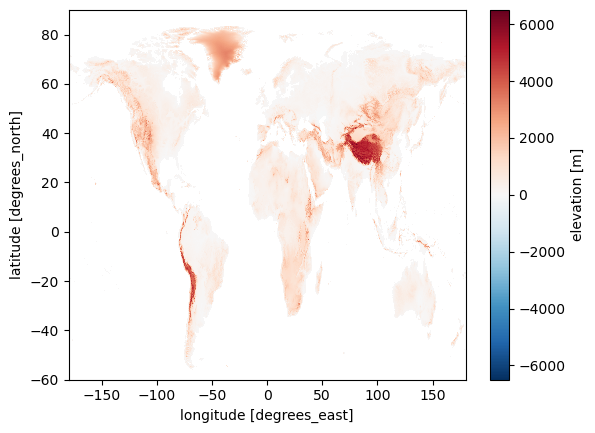

In [11]:
f='/work/hpc/datasets/un_fao/gaez_v5_intermediate/static/elev_2268708_5m.nc'
data=xr.open_dataset(f)
data.elev.plot()

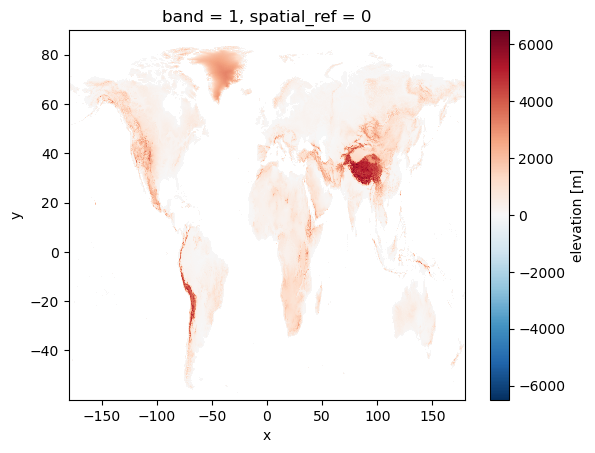

In [12]:
f='/work/hpc/datasets/un_fao/pyaez/global_static/elev_2268708_5m.tif'
data=xr.open_dataset(f)
data.band_data.plot()

In [8]:
# data = rio.open_rasterio(f)['elev']
data=xr.open_dataset(f)
data


<xarray.Dataset>
Dimensions:      (lon: 741, lat: 428, bnd: 2)
Coordinates:
  * lon          (lon) float32 73.29 73.38 73.46 73.54 ... 134.8 134.9 135.0
  * lat          (lat) float32 53.62 53.54 53.46 53.38 ... 18.21 18.12 18.04
  * bnd          (bnd) int32 0 1
Data variables:
    spatial_ref  int32 ...
    elev         (lat, lon) float32 ...
    lat_bnds     (lat, bnd) float32 ...
    lon_bnds     (lon, bnd) float32 ...
Attributes:
    grid_size:    0.0833333
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownloadChina03272023...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/asia/data...

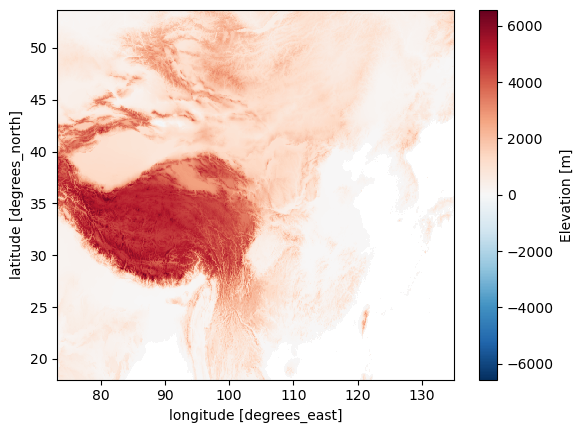

In [9]:
data.elev.plot()


In [25]:
# get file path and file name
f = glob.glob('/work/hpc/datasets/un_fao/pyaez/old/china_static/netcdf/elev_old.nc')[0]
filename='elev.nc'
print(f)
print(filename)

/work/hpc/datasets/un_fao/pyaez/old/china_static/netcdf/elev_old.nc
elev.nc


In [26]:
data = rio.open_rasterio(f)#['elev']#.sel(y=slice(90,-60.))
# data=xr.open_dataset(f)
data

/work/hpc/users/kerrie/envs/pyaezx/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/work/hpc/users/kerrie/envs/pyaezx/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/work/hpc/users/kerrie/envs/pyaezx/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/work/hpc/users/kerrie/envs/pyaezx/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix wil

[<xarray.Dataset>
 Dimensions:      (band: 1, x: 741, y: 428)
 Coordinates:
   * band         (band) int64 1
   * x            (x) float64 73.29 73.37 73.46 73.54 ... 134.7 134.8 134.9 135.0
   * y            (y) float64 53.62 53.54 53.46 53.37 ... 18.29 18.21 18.12 18.04
     spatial_ref  int64 0
 Data variables:
     elev         (band, y, x) int16 ...
 Attributes:
     grid_size:    0.0833333
     source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/asia/data...
     source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownloadChina03272023...,
 <xarray.Dataset>
 Dimensions:      (band: 1, x: 2, y: 428)
 Coordinates:
   * band         (band) int64 1
   * x            (x) float64 0.5 1.5
   * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 424.5 425.5 426.5 427.5
     spatial_ref  int64 0
 Data variables:
     lat_bnds     (band, y, x) float32 ...
 Attributes:
     grid_size:    0.0833333
     source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/asia/data...
   

In [23]:
data=data.fillna(-9999)
data.elev.attrs['_FillValue']=-9999
data

<xarray.Dataset>
Dimensions:      (lat: 428, lon: 741, bnd: 2)
Coordinates:
  * lon          (lon) float32 73.29 73.38 73.46 73.54 ... 134.8 134.9 135.0
  * lat          (lat) float32 53.62 53.54 53.46 53.38 ... 18.21 18.12 18.04
  * bnd          (bnd) int32 0 1
Data variables:
    spatial_ref  int64 0
    elev         (lat, lon) float32 114.0 117.0 122.0 ... -9.999e+03 -9.999e+03
    lat_bnds     (lat, bnd) float32 53.67 53.58 53.58 53.5 ... 18.08 18.08 18.0
    lon_bnds     (lon, bnd) float32 73.25 73.33 73.33 ... 134.9 134.9 135.0
Attributes:
    grid_size:    0.0833333
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownloadChina03272023...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/asia/data...

In [24]:

# write file
outfile='/work/hpc/datasets/un_fao/pyaez/china_test/'+filename[:-3]+'.tif'
print('writing',outfile)
data.rio.to_raster(outfile)

writing /work/hpc/datasets/un_fao/pyaez/china_test/elev.tif


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

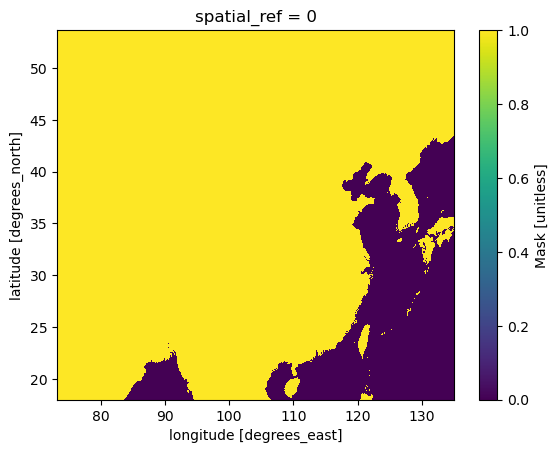

In [18]:
# get file path and file name
f ='/work/hpc/datasets/un_fao/pyaez/old/china_static/netcdf/mask_old.nc'
data=xr.open_dataset(f)
data.mask.plot()

In [19]:
data

<xarray.Dataset>
Dimensions:      (lon: 741, lat: 428, bnd: 2)
Coordinates:
  * lon          (lon) float32 73.29 73.38 73.46 73.54 ... 134.8 134.9 135.0
  * lat          (lat) float32 53.62 53.54 53.46 53.38 ... 18.21 18.12 18.04
    spatial_ref  int32 ...
  * bnd          (bnd) int32 0 1
Data variables:
    mask         (lat, lon) int8 ...
    lat_bnds     (lat, bnd) float32 ...
    lon_bnds     (lon, bnd) float32 ...
Attributes:
    grid_size:    0.0833333
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownloadChina03272023...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/asia/data...

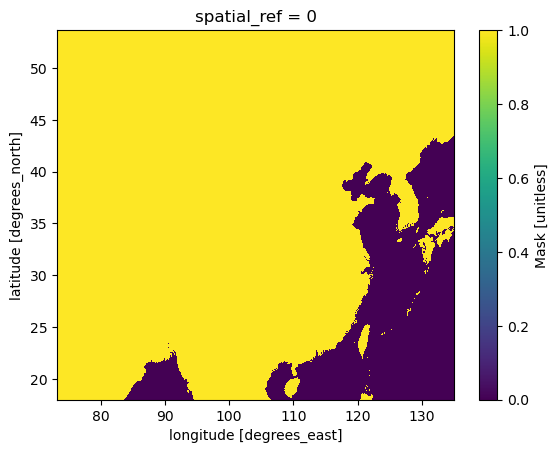

In [20]:
f ='/work/hpc/datasets/un_fao/pyaez/old/china_static/netcdf/mask.nc'
data=xr.open_dataset(f)
data.mask.plot()

In [12]:
# get file path and file name
f ='/work/hpc/datasets/un_fao/pyaez/old/china_static/altmed05_CPR.rst'
data=xr.open_dataset(f,engine='rasterio').squeeze()['band_data'] 
# data=data.fillna(-9999)
# data.band_data.attrs['_FillValue']=-9999
# data.band_data.attrs['missing_value']=-9999

# data=rio.open_rasterio(f)
data

<xarray.DataArray 'band_data' (y: 428, x: 741)>
[317148 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 73.29 73.38 73.46 73.54 ... 134.7 134.8 134.9 135.0
  * y            (y) float64 53.63 53.54 53.46 53.38 ... 18.29 18.21 18.13 18.04
    spatial_ref  int64 ...
Attributes:
    units:    unspecified

In [8]:
del data.attrs['_FillValue']

In [3]:
# data.band_data.min().values
data.min().values
# import numpy as np
# np.unique(data.band_data)

array(-152., dtype=float32)

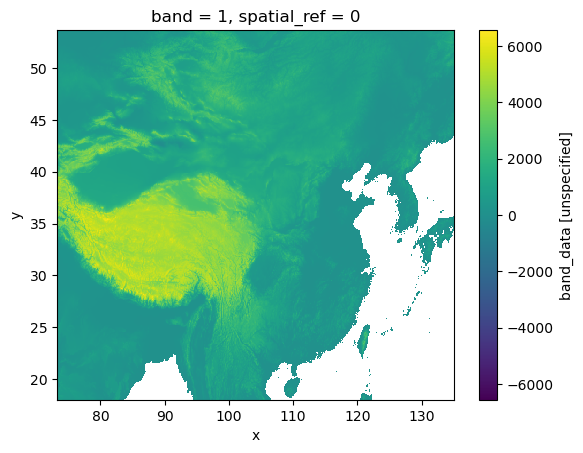

In [4]:
# data.band_data.plot(cmap='viridis')
data.plot(cmap='viridis')

In [13]:
filename='elev.tif'
outfile='/work/hpc/datasets/un_fao/pyaez/china_test/'+filename
print('writing',outfile)
# data.rio.write_nodata(np.nan, inplace=True)
# data
data.rio.to_raster(outfile)

writing /work/hpc/datasets/un_fao/pyaez/china_test/elev.tif


In [14]:
f ='/work/hpc/datasets/un_fao/pyaez/china_test/elev.tif'
data=xr.open_dataset(f,engine='rasterio').squeeze() 
data

<xarray.Dataset>
Dimensions:      (x: 741, y: 428)
Coordinates:
    band         int64 1
  * x            (x) float64 73.29 73.38 73.46 73.54 ... 134.7 134.8 134.9 135.0
  * y            (y) float64 53.63 53.54 53.46 53.38 ... 18.29 18.21 18.13 18.04
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

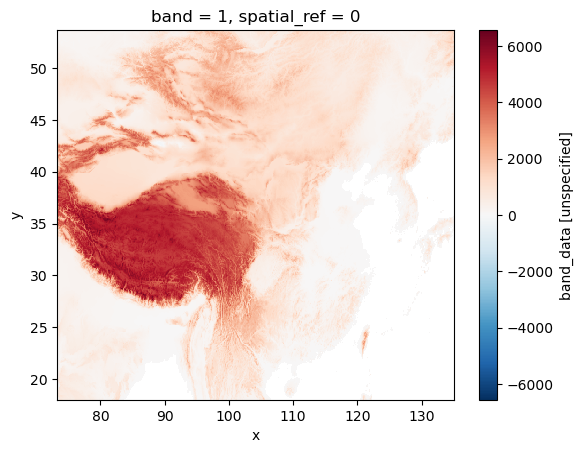

In [15]:
data.band_data.plot()